# Trends: data exploration

## TODO
- define IS and OOS
- define how to merge both trend and market datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from IPython.display import display, HTML, Markdown

## Create trends df from daily information

In [5]:
trends_path = os.path.join('data','daily',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_df = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    trends_df.append(df[name])

final_date = "2020-07-25"
trends_df = pd.concat(trends_df,1)
trends_df = trends_df[:final_date]
trends_df = trends_df.fillna(0.0)
trends_df = trends_df / 100
display(Markdown("### Merget trend frequency"))
display(HTML(trends_df.tail().to_html()))
display(Markdown("#### data shape = {}".format(trends_df.shape)))


### Merget trend frequency

,religion,investment,committee,invest,rare,war,debt,judge,house,market,cash,seats,bonds,pennsylvania,georgia,water,greed,conty,massachusetts,secretary,virginia,served,leverage,governor,car,BUY AND HOLD,freedom,stocks,food,crisis,arts,DOW JONES,movement,hedge,money,forex,consume,markets,present,chance,council,crash,labor,color,democratic,environment,earths,happy,police,fun,gold,short,federal,world,college,rights,fed,credit,default,members,cancer,case,travel,consumption,stats,political,bubble,conflict,economy,headlines,garden,gain,buy,opportunity,society,housing,banking,tennessee,carolina,act,york,court,rich,ministry,stock
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-21,0.01,0.01,0.0,0.0,0.01,0.03,0.01,0.03,0.19,0.08,0.04,0.01,0.0,0.02,0.05,0.16,0.0,0.0,0.02,0.01,0.05,0.0,0.0,0.02,0.20,0.0,0.01,0.02,0.18,0.0,0.01,0.04,0.01,0.0,0.07,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.07,0.00,0.0,0.0,0.04,0.05,0.02,0.06,0.04,0.05,0.10,0.09,0.01,0.01,0.14,0.01,0.01,0.04,0.06,0.05,0.0,0.02,0.01,0.01,0.0,0.0,0.0,0.05,0.01,0.14,0.0,0.02,0.02,0.01,0.03,0.05,0.03,0.09,0.06,0.01,0.0,0.22
2020-07-22,0.01,0.01,0.0,0.0,0.01,0.03,0.01,0.02,0.19,0.08,0.04,0.01,0.0,0.02,0.05,0.16,0.0,0.0,0.02,0.01,0.05,0.0,0.0,0.02,0.20,0.0,0.01,0.02,0.18,0.0,0.01,0.04,0.01,0.0,0.07,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.07,0.00,0.0,0.0,0.04,0.05,0.02,0.07,0.04,0.05,0.11,0.10,0.01,0.01,0.14,0.01,0.01,0.04,0.05,0.05,0.0,0.02,0.01,0.01,0.0,0.0,0.0,0.05,0.01,0.14,0.0,0.02,0.02,0.01,0.03,0.05,0.03,0.09,0.06,0.01,0.0,0.22
2020-07-23,0.01,0.01,0.0,0.0,0.01,0.03,0.01,0.01,0.19,0.08,0.04,0.01,0.0,0.02,0.05,0.16,0.0,0.0,0.02,0.01,0.05,0.0,0.0,0.02,0.20,0.0,0.01,0.02,0.19,0.0,0.01,0.04,0.01,0.0,0.08,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.07,0.00,0.0,0.0,0.04,0.05,0.02,0.06,0.04,0.05,0.11,0.09,0.01,0.01,0.14,0.01,0.01,0.04,0.05,0.05,0.0,0.02,0.01,0.01,0.0,0.0,0.0,0.05,0.01,0.15,0.0,0.02,0.02,0.01,0.03,0.05,0.03,0.09,0.05,0.01,0.0,0.21
2020-07-24,0.01,0.01,0.0,0.0,0.01,0.03,0.01,0.01,0.19,0.08,0.04,0.01,0.0,0.02,0.05,0.16,0.0,0.0,0.02,0.01,0.05,0.0,0.0,0.02,0.20,0.0,0.01,0.01,0.20,0.0,0.01,0.04,0.01,0.0,0.07,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.07,0.01,0.0,0.0,0.04,0.05,0.02,0.07,0.04,0.05,0.11,0.09,0.01,0.01,0.14,0.01,0.01,0.03,0.05,0.04,0.0,0.02,0.01,0.01,0.0,0.0,0.0,0.05,0.01,0.14,0.0,0.02,0.02,0.01,0.03,0.05,0.03,0.09,0.05,0.01,0.0,0.19
2020-07-25,0.01,0.01,0.0,0.0,0.01,0.03,0.01,0.01,0.22,0.09,0.04,0.01,0.0,0.02,0.05,0.18,0.0,0.0,0.02,0.01,0.05,0.0,0.0,0.01,0.22,0.0,0.01,0.01,0.23,0.0,0.01,0.01,0.01,0.0,0.07,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.07,0.00,0.0,0.0,0.04,0.04,0.02,0.07,0.04,0.04,0.12,0.07,0.01,0.01,0.11,0.00,0.01,0.03,0.05,0.04,0.0,0.02,0.01,0.01,0.0,0.0,0.0,0.07,0.01,0.15,0.0,0.02,0.01,0.01,0.03,0.05,0.02,0.08,0.04,0.01,0.0,0.09


#### data shape = (3859, 85)

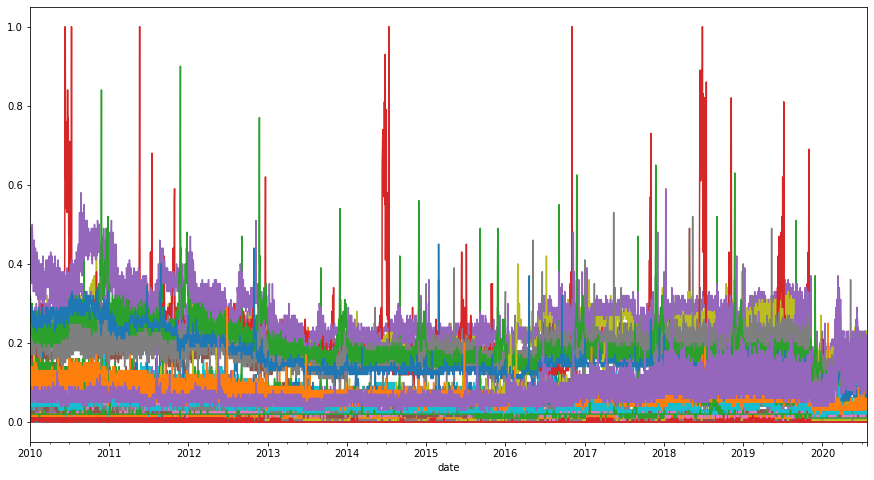

In [6]:
fig, ax = plt.subplots(figsize=(15,8))
trends_df.plot(ax=ax,legend=False);

## Word Signal

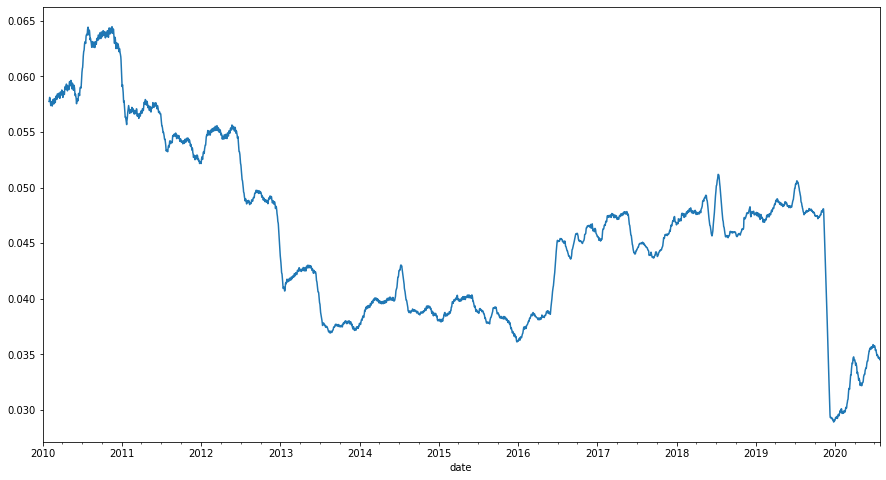

In [7]:
display(Markdown("## Word Signal"))
fig, ax = plt.subplots(figsize=(15,8))
trends_df.mean(1).rolling(30).mean().plot(ax=ax,legend=False);